In [24]:
import pandas as pd

column_names = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
    "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"
]
df_raw = pd.read_csv('..//Heart-Disease-UCI//cleveland.data', names=column_names, encoding='latin1')


df_raw = df_raw.replace("?", pd.NA).apply(pd.to_numeric, errors='coerce')
df_raw = df_raw.dropna()
df_raw.to_csv('..//Heart-Disease-UCI//heart_disease_cleaned.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
import joblib

In [6]:
df = pd.read_csv('heart_disease_cleaned.csv')

In [28]:
# 🎯 Prepare Features and Target (Binary Classification)
X = df.drop("target", axis=1)
y = (df["target"] > 0).astype(int)  # 0 = no disease, 1 = has disease

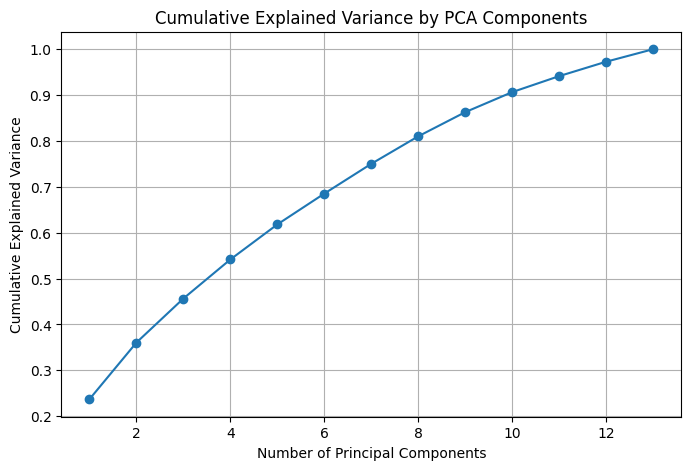

In [29]:
# 🔍 PCA Analysis
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# رسم التباين التراكمي
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


In [30]:
# ⭐ Feature Selection using RF, RFE, Chi2
rf = RandomForestClassifier(random_state=42)
rf.fit(X_scaled, y)
importances = rf.feature_importances_

# Top features by Random Forest
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# RFE Selection
rfe_selector = RFE(estimator=rf, n_features_to_select=5)
rfe_selector.fit(X_scaled, y)
rfe_selected = X.columns[rfe_selector.support_]

# Chi2 Selection (use MinMaxScaler)
X_minmax = MinMaxScaler().fit_transform(X)
chi2_selector = SelectKBest(score_func=chi2, k=5)
chi2_selector.fit(X_minmax, y)
chi2_selected = X.columns[chi2_selector.get_support()]

print("🔸 RandomForest Top:", feature_importance_df["Feature"].head(5).tolist())
print("🔸 RFE Selected:", rfe_selected.tolist())
print("🔸 Chi2 Selected:", chi2_selected.tolist())


🔸 RandomForest Top: ['thalach', 'thal', 'cp', 'ca', 'oldpeak']
🔸 RFE Selected: ['age', 'cp', 'thalach', 'oldpeak', 'thal']
🔸 Chi2 Selected: ['exang', 'oldpeak', 'slope', 'ca', 'thal']


In [31]:
# 🤖 Train 4 Supervised Models
X_selected = df[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']]  # بناءً على Feature Selection
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba)
    })

pd.DataFrame(results).sort_values(by="ROC AUC", ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.800000,0.772727,0.708333,0.739130,0.849537
2,Random Forest,0.700000,0.615385,0.666667,0.640000,0.771412
3,SVM,0.616667,0.529412,0.375000,0.439024,0.669560
1,Decision Tree,0.633333,0.529412,0.750000,0.620690,0.652778


c:\Users\Marwan Yasser\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Marwan Yasser\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\Marwan Yasser\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\Marwan Yasser\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Marwan Yasser\AppData\

KMeans ARI: 0.192
Hierarchical ARI: 0.147


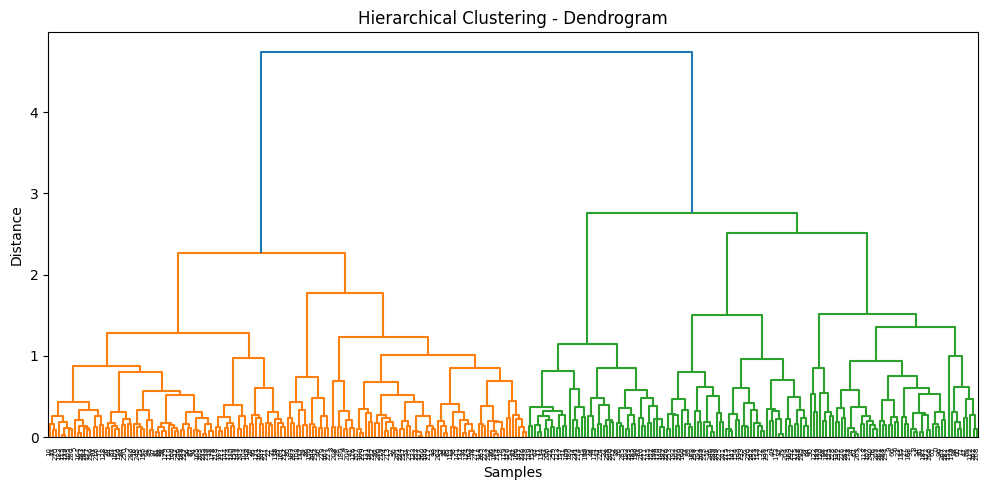

In [32]:
# 🧩 Clustering
X_cluster = MinMaxScaler().fit_transform(X_selected)

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_cluster)

hier = AgglomerativeClustering(n_clusters=2)
hier_labels = hier.fit_predict(X_cluster)

print("KMeans ARI:", round(adjusted_rand_score(y, kmeans_labels), 3))
print("Hierarchical ARI:", round(adjusted_rand_score(y, hier_labels), 3))

# Dendrogram
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(10, 5))
sch.dendrogram(sch.linkage(X_cluster, method='ward'))
plt.title("Hierarchical Clustering - Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

In [33]:
# 🔧 Hyperparameter Tuning for Logistic Regression
param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs", "liblinear"]
}

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring="roc_auc")
grid.fit(X_train, y_train)
best_model = grid.best_estimator_

print("Best Params:", grid.best_params_)
print("ROC AUC (tuned):", roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]))


Best Params: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
ROC AUC (tuned): 0.8414351851851852


In [34]:
# 💾 Save Final Model
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", best_model)
])

pipeline.fit(X_selected, y)
joblib.dump(pipeline, "final_model.pkl")

['final_model.pkl']